## Cell cycle and cell number adjusted integration

In [1]:
import scanpy as sc, numpy as np, pandas as pd
import scvi

Global seed set to 0


In [2]:
import torch
print(torch.cuda.is_available())

True


In [3]:
from matplotlib.pyplot import rc_context
from matplotlib import pyplot as plt

In [4]:
adata = sc.read("E13-TPD4.processed.concatenated.h5ad")

Only considering the two last: ['.concatenated', '.h5ad'].
Only considering the two last: ['.concatenated', '.h5ad'].


In [5]:
#adata.var_names = adata.var["features"]
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

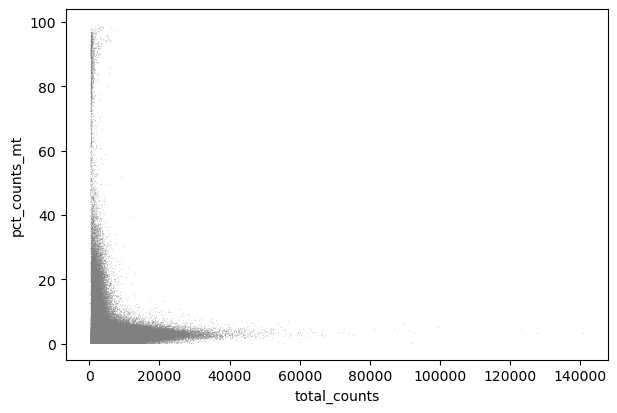

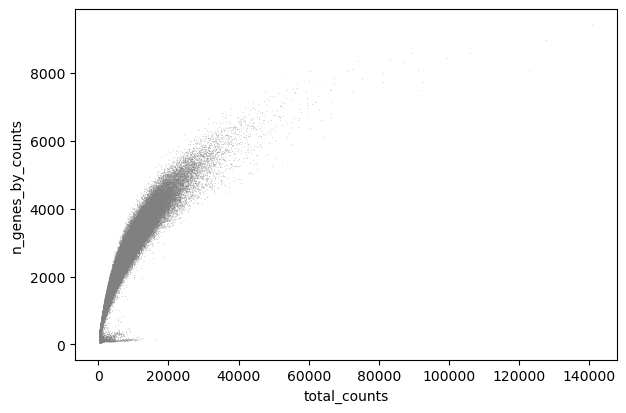

In [6]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', groups="batch")
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [7]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [8]:
s_genes = [x.strip() for x in open('s.genes.txt')]

In [9]:
s_genes

['Mcm4',
 'Exo1',
 'Slbp',
 'Gmnn',
 'Cdc45',
 'Msh2',
 'Mcm6',
 'Rrm2',
 'Pold3',
 'Blm',
 'Ubr7',
 'Mcm5',
 'Clspn',
 'Hells',
 'Nasp',
 'Rpa2',
 'Rad51ap1',
 'Tyms',
 'Rrm1',
 'Rfc2',
 'Prim1',
 'Brip1',
 'Usp1',
 'Ung',
 'Pola1',
 'Mcm2',
 'Fen1',
 'Tipin',
 'Pcna',
 'Cdca7',
 'Uhrf1',
 'Casp8ap2',
 'Cdc6',
 'Dscc1',
 'Wdr76',
 'E2f8',
 'Dtl',
 'Ccne2',
 'Atad2',
 'Gins2',
 'Chaf1b',
 'Pcna']

In [10]:
g2m_genes = [x.strip() for x in open('g2m.genes.txt')]

In [11]:
g2m_genes

['Nuf2',
 'Psrc1',
 'Ncapd2',
 'Ccnb2',
 'Smc4',
 'Lbr',
 'Tacc3',
 'Cenpa',
 'Kif23',
 'Cdca2',
 'Anp32e',
 'G2e3',
 'Cdca3',
 'Anln',
 'Cenpe',
 'Gas2l3',
 'Tubb4b',
 'Cenpf',
 'Dlgap5',
 'Hjurp',
 'Cks1brt',
 'Gtse1',
 'Bub1',
 'Birc5',
 'Ube2c',
 'Rangap1',
 'Hmmr',
 'Ect2',
 'Tpx2',
 'Ckap5',
 'Cbx5',
 'Nek2',
 'Ttk',
 'Cdca8',
 'Nusap1',
 'Ctcf',
 'Cdc20',
 'Cks2',
 'Mki67',
 'Tmpo',
 'Ckap2l',
 'Aurkb',
 'Kif2c',
 'Cdk1',
 'Kif20b',
 'Top2a',
 'Aurka',
 'Ckap2',
 'Hmgb2',
 'Cdc25c',
 'Ndc80',
 'Kif11']

In [12]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

/mnt/gmi-l1/_90.User_Data/revolvefire/anaconda3/envs/scvi-env-rollback/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/mnt/gmi-l1/_90.User_Data/revolvefire/anaconda3/envs/scvi-env-rollback/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


In [13]:
adata.obs.S_score

AAACCTGAGAGACTAT-1-0    -0.641605
AAACCTGAGCCAGTAG-1-0    -0.474776
AAACCTGAGCTATGCT-1-0    -0.712413
AAACCTGAGGAGTCTG-1-0    -0.638877
AAACCTGAGTAGCCGA-1-0    -0.283718
                           ...   
TTTGTTGGTCGAGCTC-1-12    0.026227
TTTGTTGGTCGATGCC-1-12   -0.754670
TTTGTTGTCAAACTGC-1-12   -0.120759
TTTGTTGTCGTCGACG-1-12   -0.870393
TTTGTTGTCGTGGGAA-1-12   -0.560212
Name: S_score, Length: 130517, dtype: float64

In [14]:
adata = adata[adata.obs.n_genes_by_counts > 1000, 0:]
adata = adata[adata.obs.pct_counts_mt < 7.5, :]

In [15]:
adata.layers["counts"] = adata.X.copy() # preserve counts for scVI

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

adata.raw = adata # freeze the state in `.raw`

/tmp/ipykernel_30381/4174979886.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata.layers["counts"] = adata.X.copy() # preserve counts for scVI


In [16]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=5500,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="batch"
)

/mnt/gmi-l1/_90.User_Data/revolvefire/anaconda3/envs/scvi-env-rollback/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


In [17]:
#adata.write("E13-TPD4.processed.concatenated.hvg.h5ad")

In [18]:
#adata = sc.read("E13-TPD4.processed.concatenated.hvg.h5ad")

In [19]:
#with gpu
scvi.model.SCVI.setup_anndata(adata,
                              layer="counts", batch_key="batch",
                             continuous_covariate_keys=["pct_counts_mt", "S_score", "G2M_score"])                         
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood="nb") #We note that these parameters are non-default; however, they have been verified to generally work well in the integration task.
vae.train()

/mnt/gmi-l1/_90.User_Data/revolvefire/anaconda3/envs/scvi-env-rollback/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:90: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(
/mnt/gmi-l1/_90.User_Data/revolvefire/anaconda3/envs/scvi-env-rollback/lib/python3.9/site-packages/scvi/model/base/_training_mixin.py:67: UserWarning: max_epochs=78 is less than n_epochs_kl_warmup=400. The max_kl_weight will not be reached during training.
  warnings.warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 78/78: 100%|██████████| 78/78 [20:27<00:00, 15.74s/it, loss=1.76e+03, v_num=1]


In [20]:
#vae.save("230214.cellcycle.regressout.sciviintegration.model")

In [21]:
adata.obsm["X_scVI"] = vae.get_latent_representation()

In [22]:
adata.layers["scvi_normalized"] = vae.get_normalized_expression(
    library_size=10e4
)
adata

AnnData object with n_obs × n_vars = 102044 × 5500
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'nCount_RNA', 'nFeature_RNA', 'ident', 'scDblFinder.class', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.cxds_score', 'bulk.ident', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'S_score', 'G2M_score', 'phase', '_scvi_batch', '_scvi_labels'
    var: 'scDblFinder.selected-0', 'scDblFinder.selected-1', 'scDblFinder.selected-10', 'scDblFinder.selected-11', 'scDblFinder.selected-12', 'scDblFinder.selected-2', 'scDblFinder.selected-3', 'scDblFinder.selected-4', 'scDblFinder.selected-5', 'scDblFinder.selected-6', 'scDblFinder.selected-7', 'scDblFinder.selected-8', 'scDblFinder.selected-9', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'log1p', 'hvg', 

In [23]:
# run PCA then generate UMAP plots
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=20)
sc.tl.umap(adata, min_dist=0.3)

In [24]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.3)

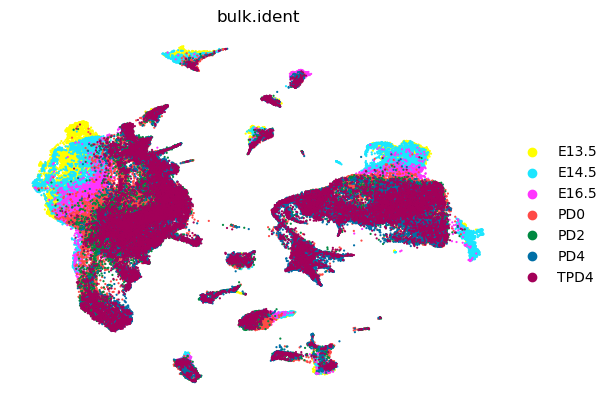

In [25]:
sc.pl.umap(
    adata,
    color=["bulk.ident"],
    frameon=False, palette=sc.pl.palettes.default_102, size=10
)

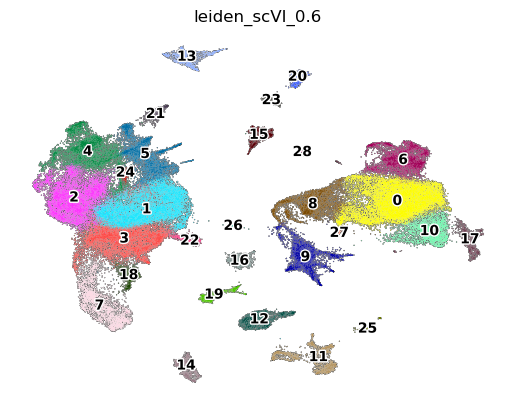

In [26]:
sc.tl.leiden(adata, key_added="leiden_scVI_0.6", resolution=0.6)
sc.pl.umap(
    adata,
    color=["leiden_scVI_0.6"],
    frameon=False, palette=sc.pl.palettes.default_102, add_outline=True, legend_loc='on data',legend_fontoutline=2,
)

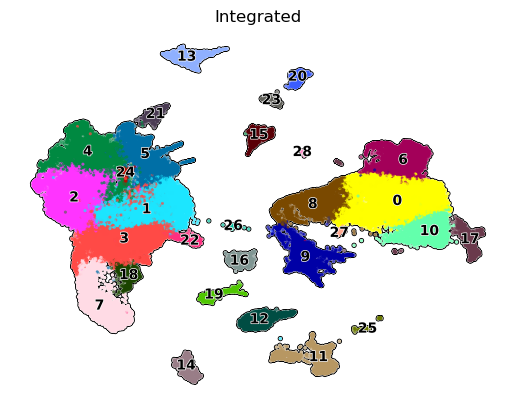

In [27]:
sc.pl.umap(
    adata,
    color=["leiden_scVI_0.6"],
    frameon=False, title="Integrated", add_outline=True, size=20, legend_loc='on data',legend_fontoutline=1, legend_fontsize='medium', save='230214.integrated.cellcycleregressed.pdf'
)

In [28]:
def cluster_small_multiples(
    adata, clust_key, size=30, frameon=False, legend_loc=None, **kwargs
):
    tmp = adata.copy()

    for i, clust in enumerate(adata.obs[clust_key].cat.categories):
        tmp.obs[clust] = adata.obs[clust_key].isin([clust]).astype("category")
        tmp.uns[clust + "_colors"] = ["#d3d3d3", adata.uns[clust_key + "_colors"][i]]

    sc.pl.umap(
        tmp,
        groups=tmp.obs[clust].cat.categories[1:].values,
        color=adata.obs[clust_key].cat.categories.tolist(),
        size=size,
        frameon=frameon,
        legend_loc=legend_loc, add_outline=True, save='230214.cellcycleregressed.pdf',
        **kwargs,
    )

/mnt/gmi-l1/_90.User_Data/revolvefire/anaconda3/envs/scvi-env-rollback/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/mnt/gmi-l1/_90.User_Data/revolvefire/anaconda3/envs/scvi-env-rollback/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/mnt/gmi-l1/_90.User_Data/revolvefire/anaconda3/envs/scvi-env-rollback/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories

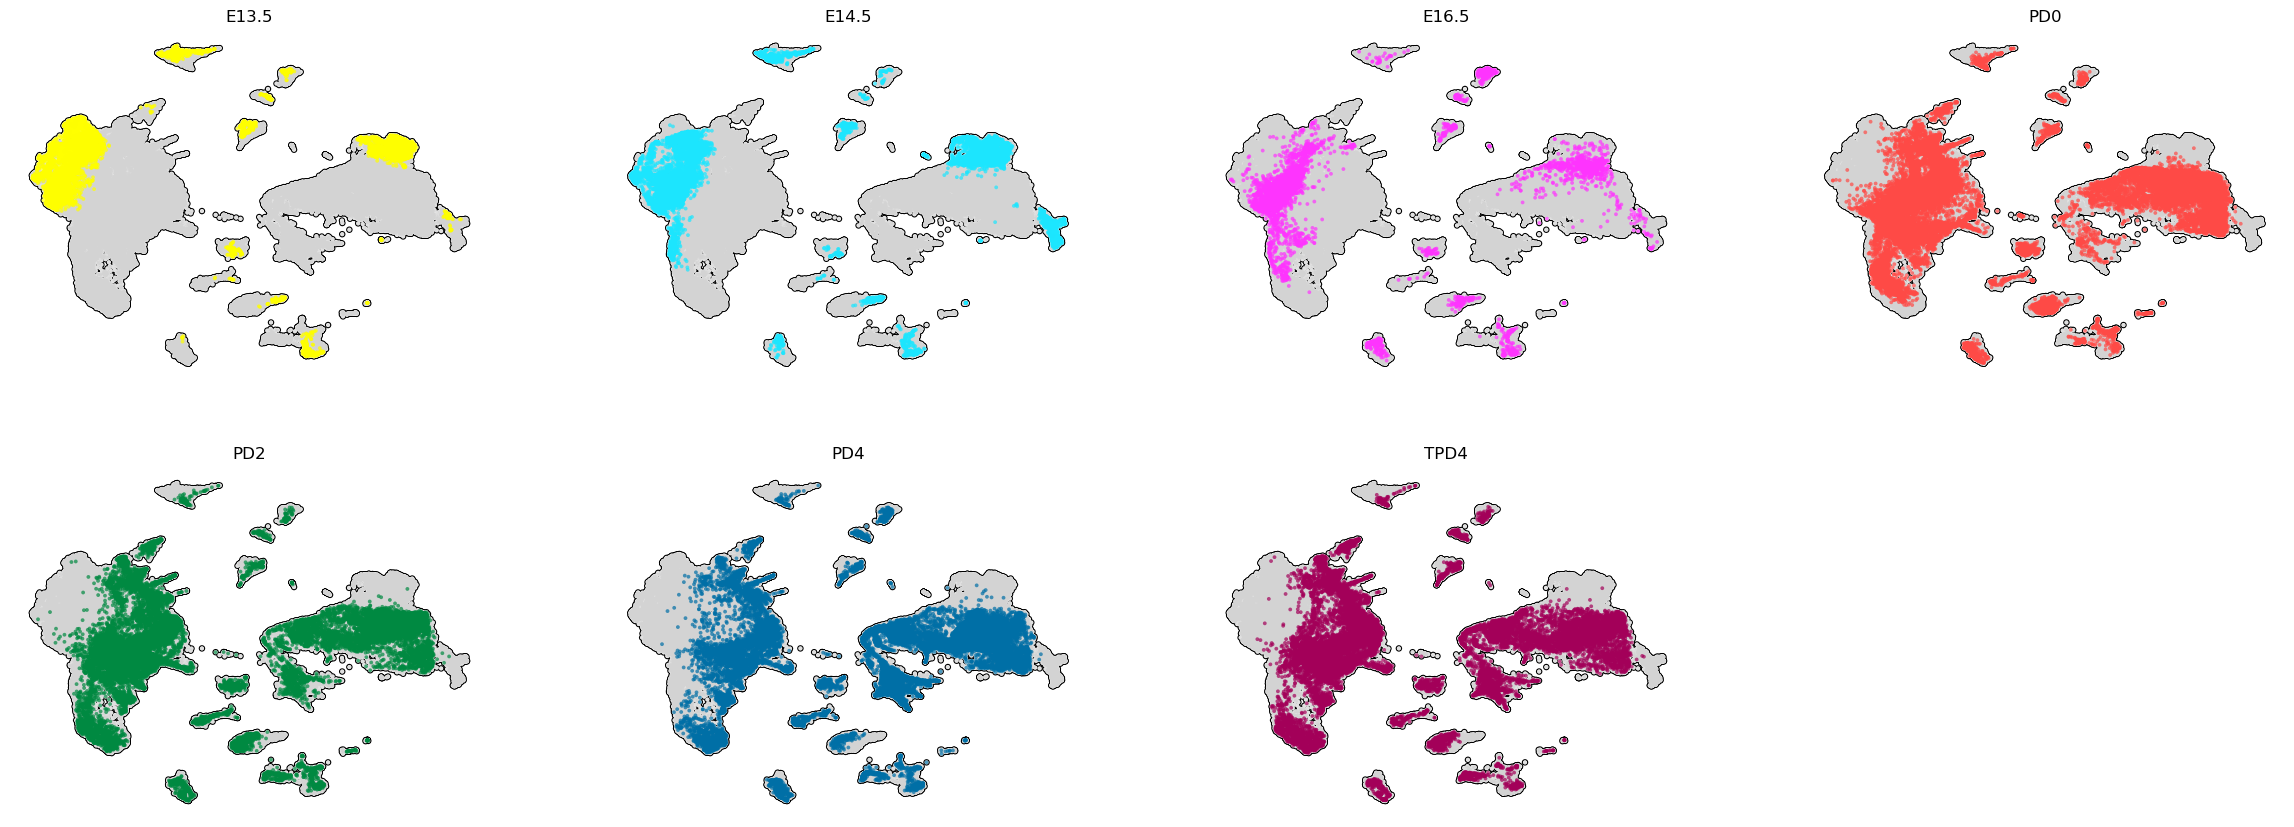

In [29]:
cluster_small_multiples(adata, "bulk.ident")

## matching cell numbers

In [30]:
scvi.settings.seed = 0

Global seed set to 0


In [31]:
adata = sc.read("E13-TPD4.downsampled.concatenated.h5ad") # ~5000cell per timepoint

Only considering the two last: ['.concatenated', '.h5ad'].
Only considering the two last: ['.concatenated', '.h5ad'].


In [32]:
#adata.var_names = adata.var["features"]
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

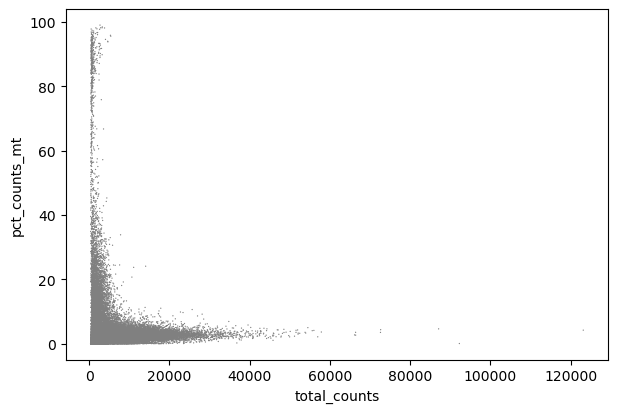

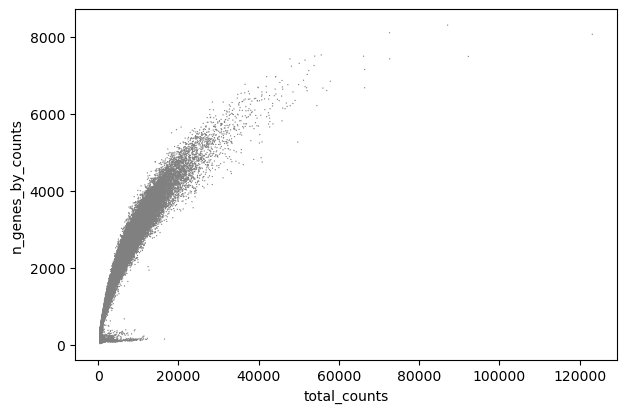

In [33]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', groups="batch")
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [34]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [35]:
adata = adata[adata.obs.n_genes_by_counts > 1000, 0:]
adata = adata[adata.obs.pct_counts_mt < 7.5, :]

In [36]:
adata.layers["counts"] = adata.X.copy() # preserve counts for scVI

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

adata.raw = adata # freeze the state in `.raw`

/tmp/ipykernel_30381/4174979886.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata.layers["counts"] = adata.X.copy() # preserve counts for scVI


In [37]:
adata

AnnData object with n_obs × n_vars = 27000 × 22506
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'nCount_RNA', 'nFeature_RNA', 'ident', 'scDblFinder.class', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.cxds_score', 'bulk.ident', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'scDblFinder.selected-0-0', 'scDblFinder.selected-1-0', 'scDblFinder.selected-0-1', 'scDblFinder.selected-1-1', 'scDblFinder.selected-2', 'scDblFinder.selected-0-3', 'scDblFinder.selected-1-3', 'scDblFinder.selected-0-4', 'scDblFinder.selected-1-4', 'scDblFinder.selected-0-5', 'scDblFinder.selected-1-5', 'scDblFinder.selected-0-6', 'scDblFinder.selected-1-6', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'log1p'
    layers: 'counts'

In [38]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=5500,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="orig.ident"
)

/mnt/gmi-l1/_90.User_Data/revolvefire/anaconda3/envs/scvi-env-rollback/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


In [39]:
#with gpu
scvi.model.SCVI.setup_anndata(adata,
                              layer="counts", batch_key="orig.ident",
                             continuous_covariate_keys=["pct_counts_mt"])                         
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood="nb") #We note that these parameters are non-default; however, they have been verified to generally work well in the integration task.
vae.train()

/mnt/gmi-l1/_90.User_Data/revolvefire/anaconda3/envs/scvi-env-rollback/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:90: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(
/mnt/gmi-l1/_90.User_Data/revolvefire/anaconda3/envs/scvi-env-rollback/lib/python3.9/site-packages/scvi/model/base/_training_mixin.py:67: UserWarning: max_epochs=296 is less than n_epochs_kl_warmup=400. The max_kl_weight will not be reached during training.
  warnings.warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 296/296: 100%|██████████| 296/296 [22:30<00:00,  4.56s/it, loss=1.89e+03, v_num=1]


In [40]:
adata.obsm["X_scVI"] = vae.get_latent_representation()

In [41]:
adata.layers["scvi_normalized"] = vae.get_normalized_expression(
    library_size=10e4
)
adata

AnnData object with n_obs × n_vars = 27000 × 5500
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'nCount_RNA', 'nFeature_RNA', 'ident', 'scDblFinder.class', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.cxds_score', 'bulk.ident', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', '_scvi_batch', '_scvi_labels'
    var: 'scDblFinder.selected-0-0', 'scDblFinder.selected-1-0', 'scDblFinder.selected-0-1', 'scDblFinder.selected-1-1', 'scDblFinder.selected-2', 'scDblFinder.selected-0-3', 'scDblFinder.selected-1-3', 'scDblFinder.selected-0-4', 'scDblFinder.selected-1-4', 'scDblFinder.selected-0-5', 'scDblFinder.selected-1-5', 'scDblFinder.selected-0-6', 'scDblFinder.selected-1-6', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'log1p', 'hvg', '_scvi_uuid',

In [42]:
# run PCA then generate UMAP plots
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=20)
sc.tl.umap(adata, min_dist=0.3)

In [43]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.3)

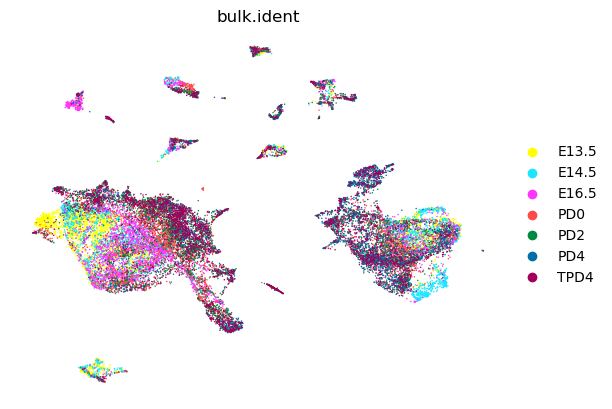

In [44]:
sc.pl.umap(
    adata,
    color=["bulk.ident"],
    frameon=False, palette=sc.pl.palettes.default_102
)

In [45]:
def cluster_small_multiples(
    adata, clust_key, size=30, frameon=False, legend_loc=None, **kwargs
):
    tmp = adata.copy()

    for i, clust in enumerate(adata.obs[clust_key].cat.categories):
        tmp.obs[clust] = adata.obs[clust_key].isin([clust]).astype("category")
        tmp.uns[clust + "_colors"] = ["#d3d3d3", adata.uns[clust_key + "_colors"][i]]

    sc.pl.umap(
        tmp,
        groups=tmp.obs[clust].cat.categories[1:].values,
        color=adata.obs[clust_key].cat.categories.tolist(),
        size=size,
        frameon=frameon,
        legend_loc=legend_loc, add_outline=True, save='i.downsample.pdf',
        **kwargs,
    )

/mnt/gmi-l1/_90.User_Data/revolvefire/anaconda3/envs/scvi-env-rollback/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/mnt/gmi-l1/_90.User_Data/revolvefire/anaconda3/envs/scvi-env-rollback/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/mnt/gmi-l1/_90.User_Data/revolvefire/anaconda3/envs/scvi-env-rollback/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories

/mnt/gmi-l1/_90.User_Data/revolvefire/anaconda3/envs/scvi-env-rollback/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


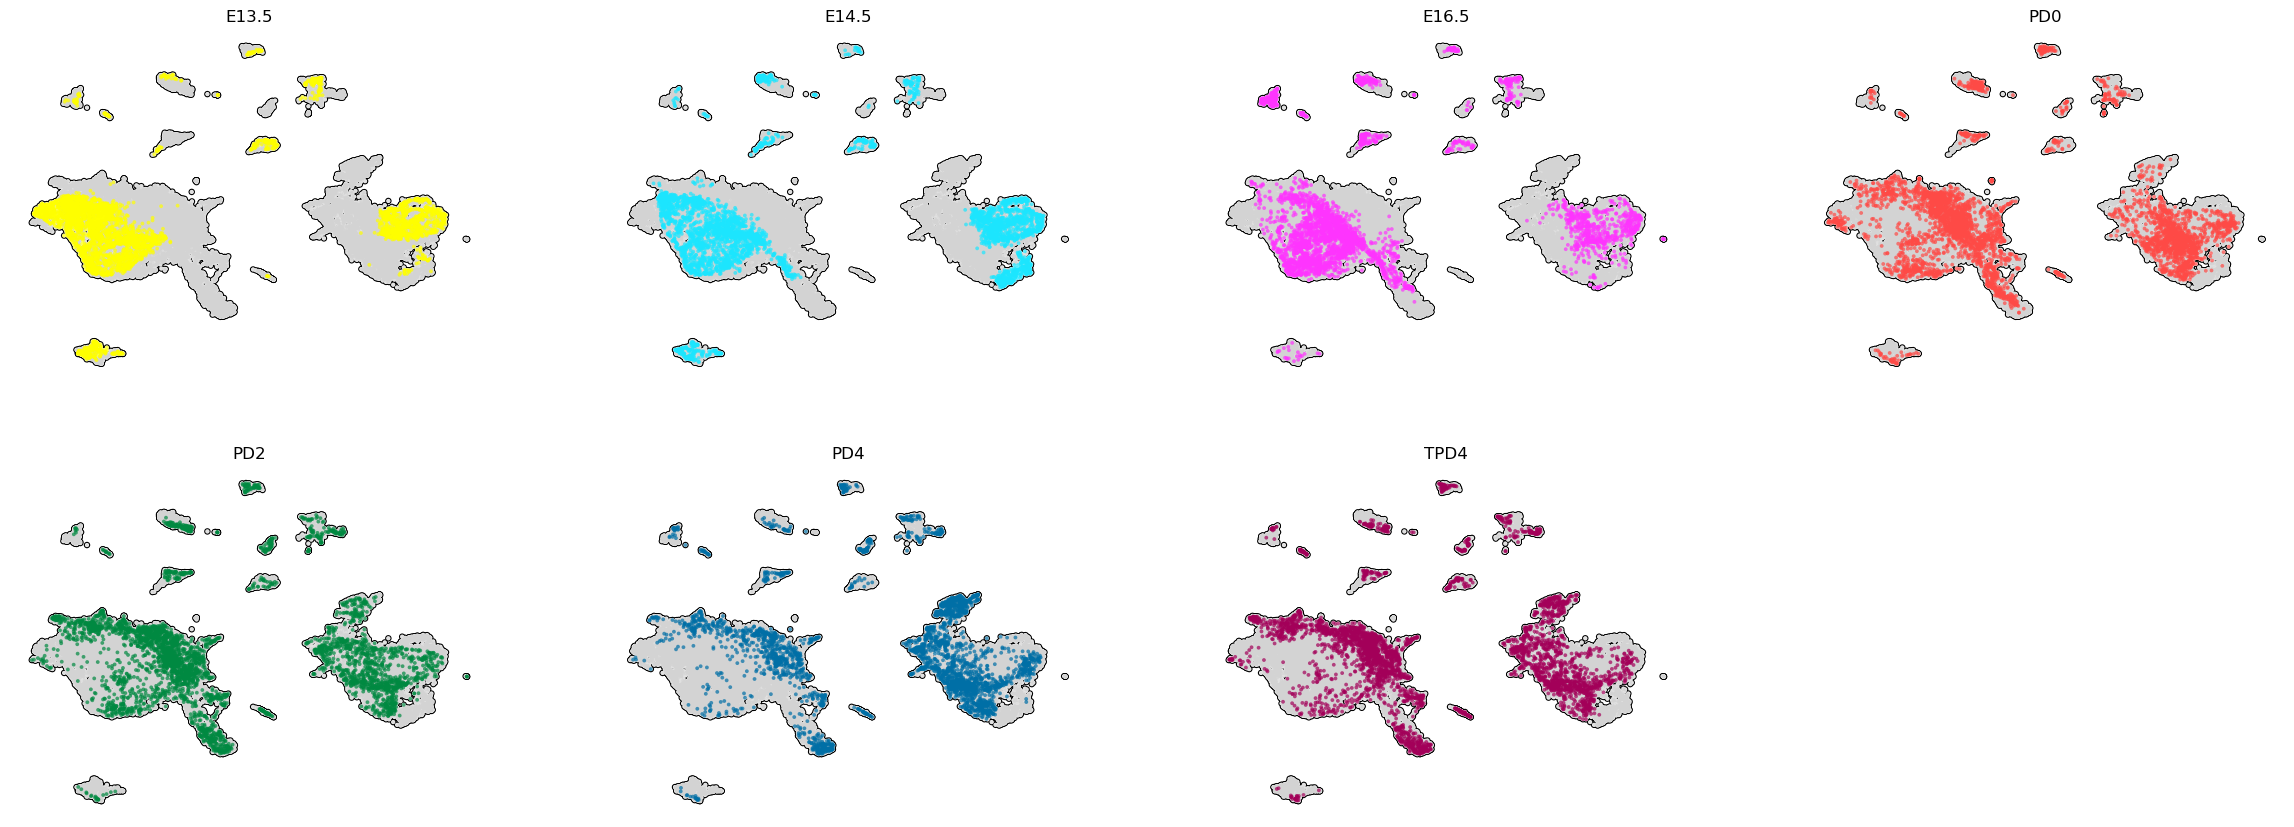

In [46]:
cluster_small_multiples(adata, "bulk.ident")

In [47]:
#adata.write("230214.adata.e13_Tpd4.hvg5500.downsample.integrated.h5ad")

In [48]:
#adata = sc.read_h5ad("adata.e13_Tpd4.hvg4000.downsample.integrated.h5ad")

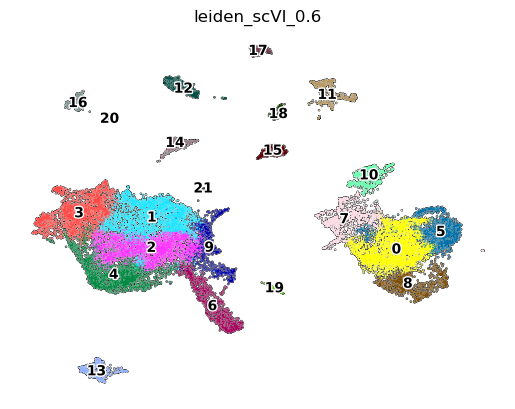

In [49]:
sc.tl.leiden(adata, key_added="leiden_scVI_0.6", resolution=0.6)
sc.pl.umap(
    adata,
    color=["leiden_scVI_0.6"],
    frameon=False, palette=sc.pl.palettes.default_102, add_outline=True, legend_loc='on data',legend_fontoutline=2,
)

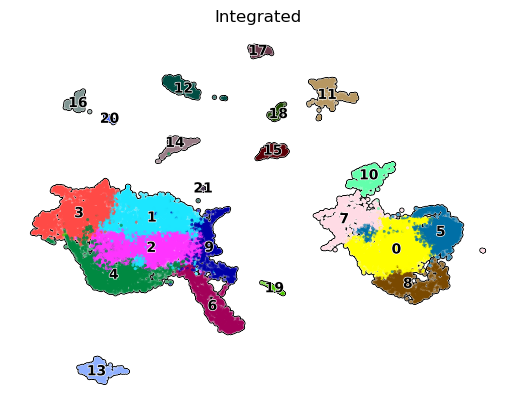

In [50]:
sc.pl.umap(
    adata,
    color=["leiden_scVI_0.6"],
    frameon=False, title="Integrated", add_outline=True, size=20, legend_loc='on data',legend_fontoutline=1, legend_fontsize='medium', save='integrated.downsample.pdf'
)

In [51]:
def cluster_gene_multiples_normalized(
    adata, gene, size=20, **kwargs
):
    
    fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(20, 10))
    sc.pl.umap(adata[adata.obs["bulk.ident"] == "E13.5"], size=20, color=[gene], frameon=True, show=False, ax=axes[0,0], title="E13.5", layer = 'scvi_normalized')
    sc.pl.umap(adata[adata.obs["bulk.ident"] == "E14.5"], size=20, color=[gene], frameon=True, show=False, ax=axes[0,1], title="E14.5", layer = 'scvi_normalized')
    sc.pl.umap(adata[adata.obs["bulk.ident"] == "E16.5"], size=20, color=[gene], frameon=True, show=False, ax=axes[0,2], title="E16.5", layer = 'scvi_normalized')
    sc.pl.umap(adata[adata.obs["bulk.ident"] == "PD0"], size=20, color=[gene], frameon=True, show=False, ax=axes[0,3], title="PD0", layer = 'scvi_normalized')
    sc.pl.umap(adata[adata.obs["bulk.ident"] == "PD2"], size=20, color=[gene], frameon=True, show=False, ax=axes[1,0], title="PD2", layer = 'scvi_normalized')
    sc.pl.umap(adata[adata.obs["bulk.ident"] == "PD4"], size=20, color=[gene], frameon=True, show=False, ax=axes[1,1], title="PD4", layer = 'scvi_normalized')
    sc.pl.umap(adata[adata.obs["bulk.ident"] == "TPD4"], size=20, color=[gene], frameon=True, show=False, ax=axes[1,2], title="TPD4", layer = 'scvi_normalized')
   # sc.pl.umap(adata[adata.obs["bulk.ident"] == "PD21W"], size=20, color=[gene], frameon=True, show=False, ax=axes[1,3], title="PD21W", layer = 'scvi_normalized')

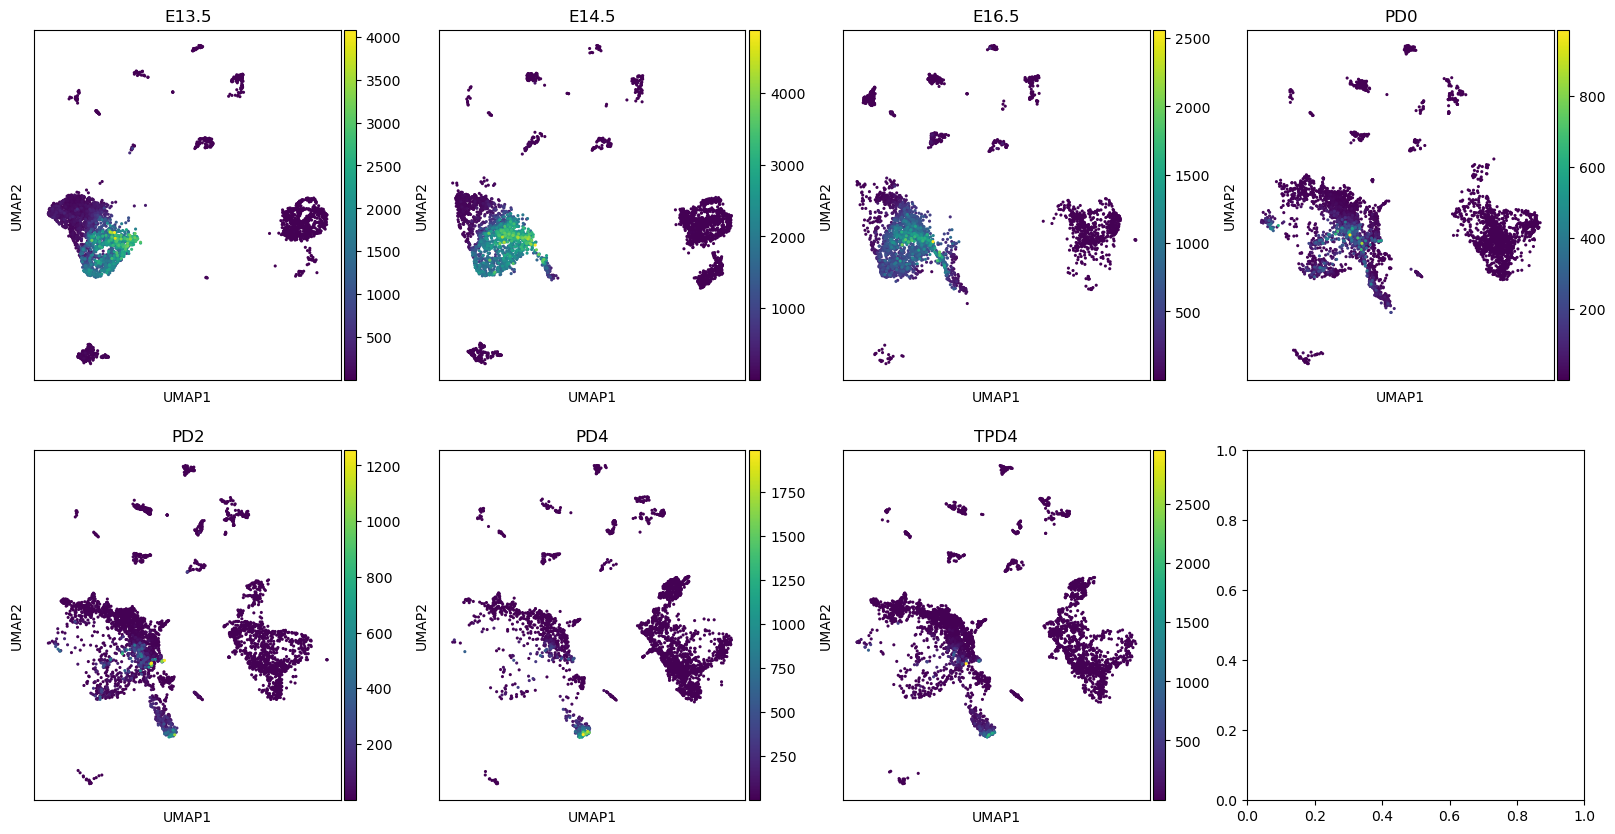

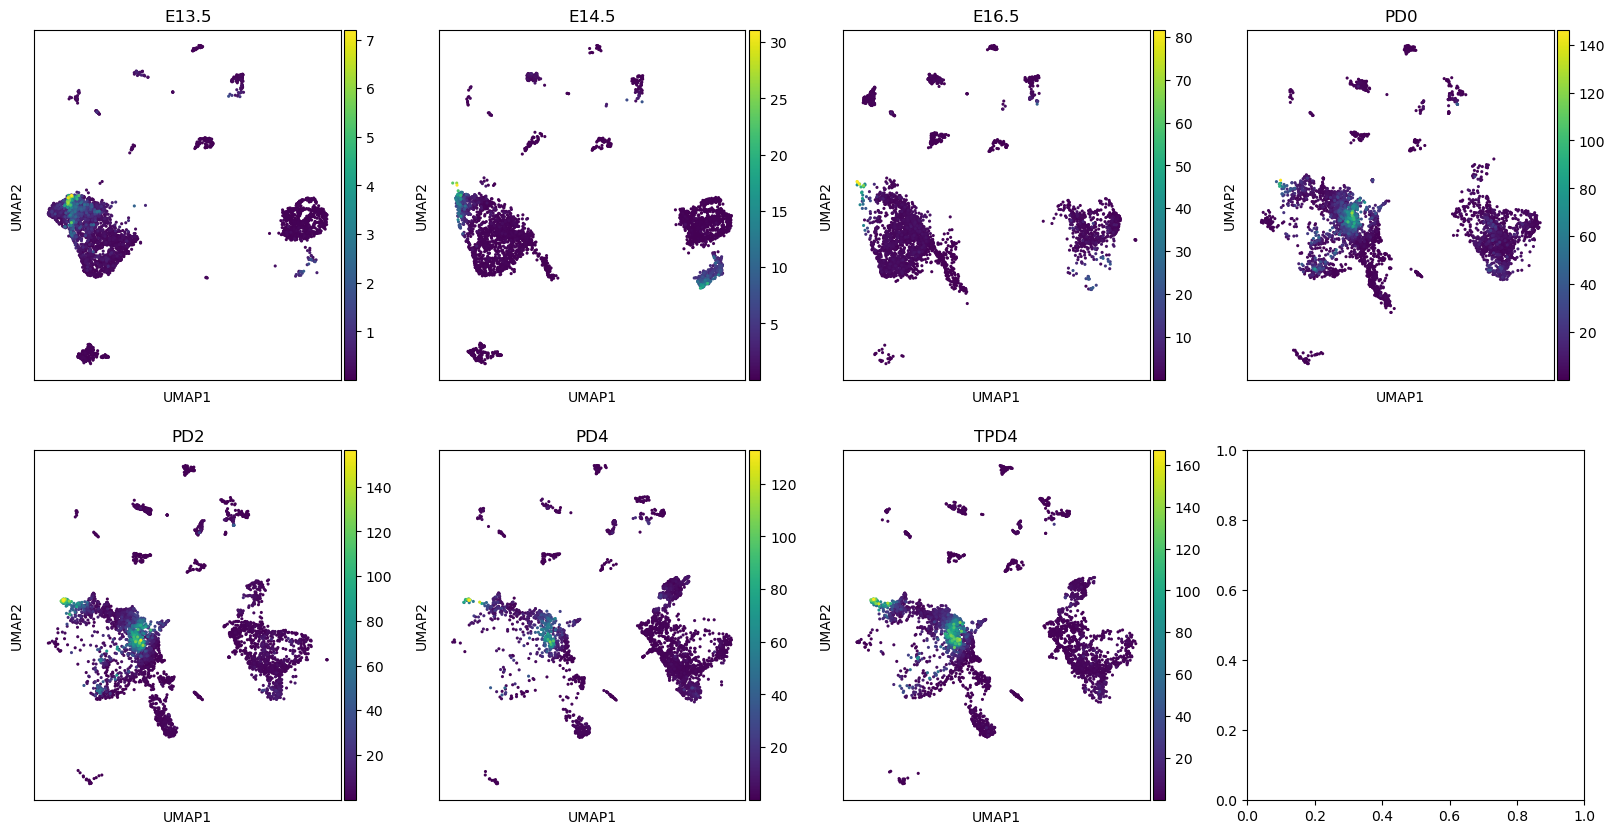

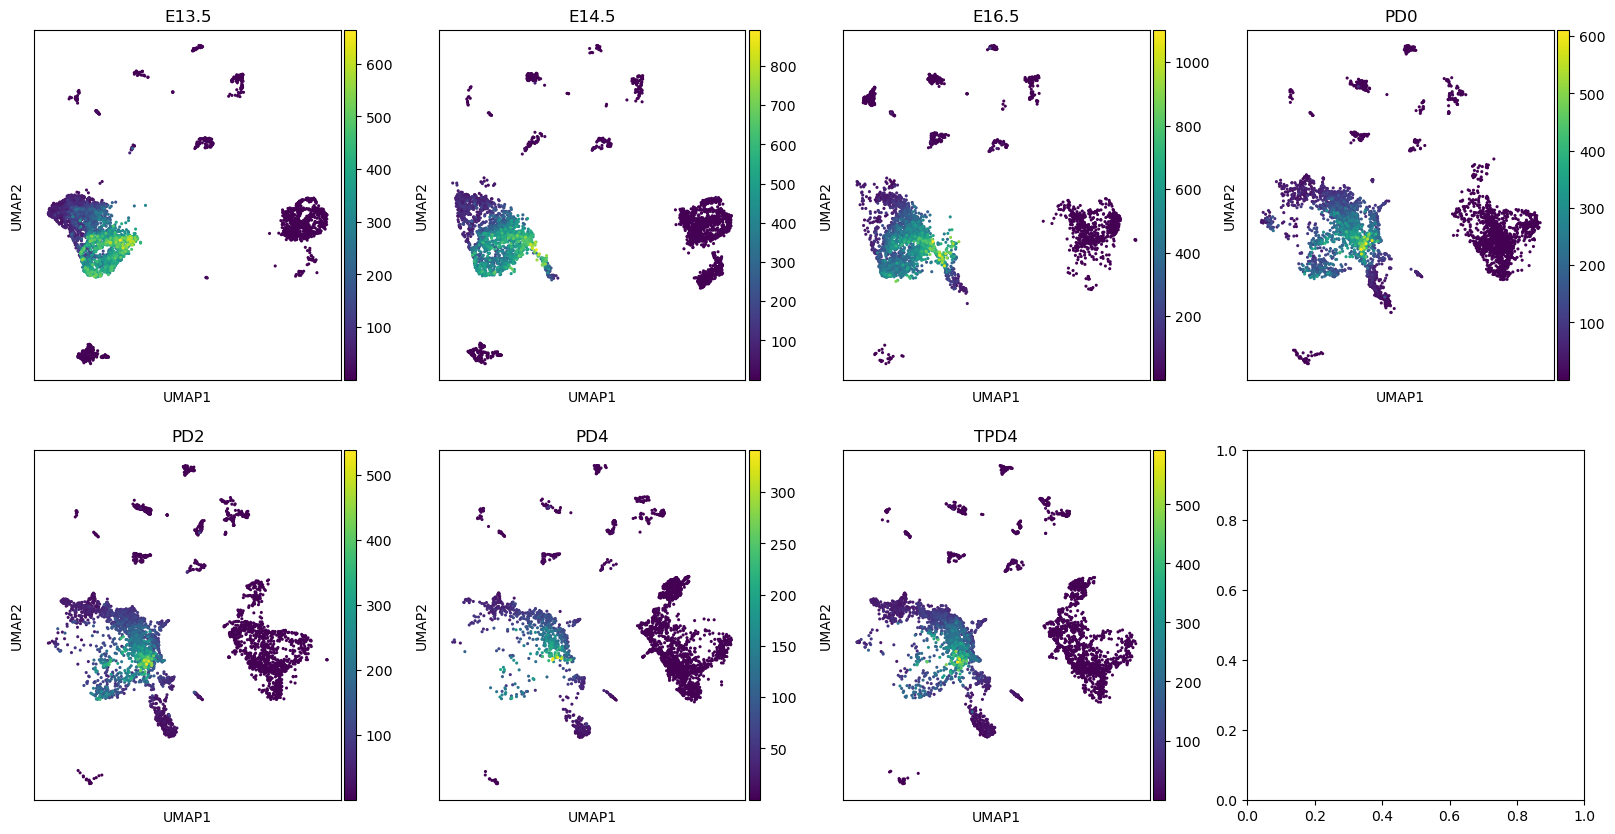

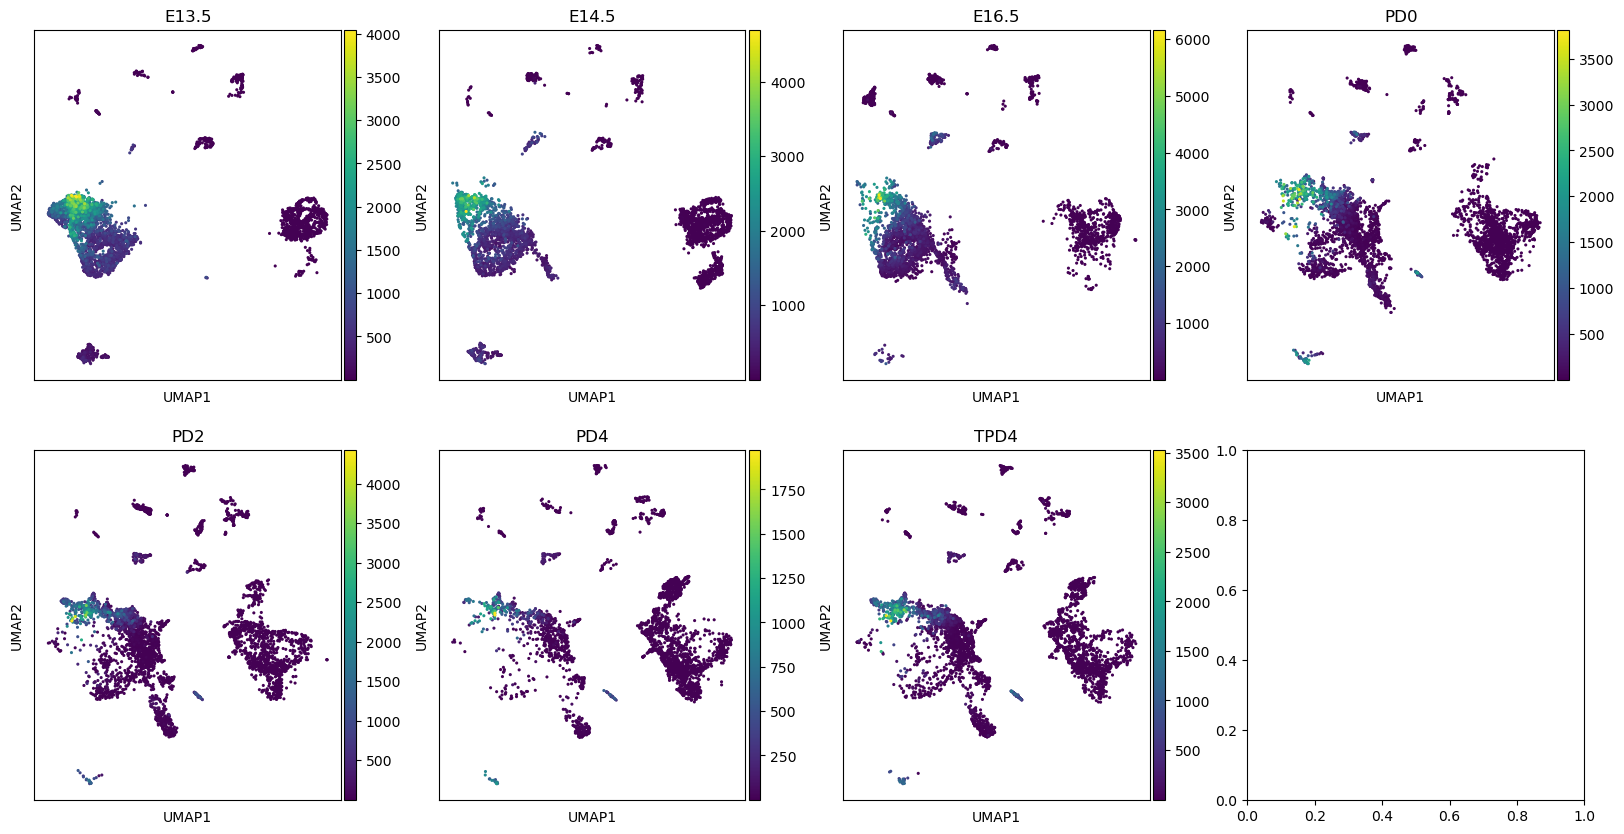

In [52]:
cluster_gene_multiples_normalized(adata, "Crabp1")
cluster_gene_multiples_normalized(adata, "Dpp4")
cluster_gene_multiples_normalized(adata, "Twist2")
cluster_gene_multiples_normalized(adata, "Dlk1")